In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, Flatten, Reshape, Cropping1D
import pandas as pd
import numpy as np
from data_preprocess import Preprocessor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [3]:
df_a0 = pd.read_csv("data/1913/ambient/1913_ambient_noise.csv", header=None)
df_a1 = pd.read_csv("data/1936/ambient/1936_ambient.csv", header=None)

In [4]:
# data, channels, sr, hz, type
# Edit the channels, hz, and type for each dataset
# channels: is given as a tuple of the channels to be used
# sr: the sampling rate of the data
# hz: the frequency of the data, given as a tuple (only one value if the hz is the same for all channels)
# type: the type of the data, given as a string of n, f, or i for each channel. f is Faulty, n is Normal, and i is Imbalanced)
data_df = [
    [df_a0, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_a1, (0, 1, 2, 3), 20000, (20,), 'nnnn']
]

In [5]:
data_interval = 4
preprocessor = Preprocessor(max_freq=600, kaiser_beta=10)
dataset = preprocessor.compute_preprocess(data_df, data_interval, shuffle=True, keep_channels_separate=False)

1 of 2 finished
2 of 2 finished


In [6]:
X = dataset[:, :-2]
X_train, X_test = train_test_split(X, test_size=0.10)
X_train, X_val = train_test_split(X, test_size=0.10)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = X_test
X_val = scaler.transform(X_val)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(2160, 2401)
(240, 2401)
(240, 2401)


In [7]:
# Function to reset keras so that a new model can be created without having to restart the kernel and reload all datasets
def reset():
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    try:
        del encoder
        del encoded
        del decoder
        del decoded
        del autoencoder
    except:
        pass

In [13]:
# create encoder
reset()
# Change model structure as needed, but ensure that the encoder and the decoder complement each other
input_shape_encoder = (X_train.shape[1],1)
input_layer_encoder = keras.Input(shape=input_shape_encoder)

encoded = Conv1D(8, kernel_size=3, activation='relu', padding='same', use_bias=True)(input_layer_encoder)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Conv1D(8, kernel_size=3, activation='relu', padding='same', use_bias=True)(encoded)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Flatten()(encoded)
encoded = Dense(1000, activation='relu', use_bias=True)(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(500, activation='relu', use_bias=True)(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(200, activation='relu', use_bias=True)(encoded)

encoder = keras.Model(input_layer_encoder, encoded)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2401, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2401, 8)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1200, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1200, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1200, 8)        │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     4,801,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │       100,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,932 (20.61 MB)

 Trainable params: 5,401,932 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
input_layer_decoder = keras.layers.Input(shape=encoder.output.shape[1:])
decoded = Dense(500, activation='relu', use_bias=True)(input_layer_decoder)
encoded = Dropout(0.1)(encoded)
decoded = Dense(1000, activation='relu', use_bias=True)(input_layer_decoder)
encoded = Dropout(0.1)(encoded)
decoded = Dense(4800, activation='relu', use_bias=True)(decoded)
decoded = Reshape(target_shape=(600, 8))(decoded)
decoded = UpSampling1D(size=2)(decoded)
decoded = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='valid', use_bias=True)(decoded)
decoded = UpSampling1D(size=2)(decoded)
decoded = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same', use_bias=True)(decoded)
decoded = Conv1D(1, kernel_size=3, activation='linear', padding='valid', use_bias=True)(decoded)
decoded = Cropping1D(cropping=(0, 1))(decoded)

decoder = keras.Model(input_layer_decoder, decoded)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │       201,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4800)           │     4,804,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 1200, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1202, 8)        │           200 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 2404, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 2404, 8)        │           200 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2402, 1)        │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 2401, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,006,225 (19.10 MB)

 Trainable params: 5,006,225 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# create autoencoder
encoded_data = encoder(input_layer_encoder)
decoded_data = decoder(encoded_data)
autoencoder = keras.Model(inputs=input_layer_encoder, outputs=decoded_data)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2401, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 200)            │     5,401,932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 2401, 1)        │     5,006,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,408,157 (39.70 MB)

 Trainable params: 10,408,157 (39.70 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss = keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss)

In [17]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_val, X_val), callbacks=[callback])

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.0000e+00 - loss: 0.6408 - val_accuracy: 0.0000e+00 - val_loss: 0.6068
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.0000e+00 - loss: 0.6028 - val_accuracy: 0.0000e+00 - val_loss: 0.5986
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.0000e+00 - loss: 0.5883 - val_accuracy: 0.0000e+00 - val_loss: 0.5832
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.0000e+00 - loss: 0.5685 - val_accuracy: 0.0000e+00 - val_loss: 0.5704
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.0000e+00 - loss: 0.5500 - val_accuracy: 0.0000e+00 - val_loss: 0.5615
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.0000e+00 - loss: 0.5387 - val_accuracy: 0.0000e+00 - val_loss: 0.5512
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0000e+00 - loss: 0.5311 - val_accuracy: 0.0000e+00 - val_loss: 0.5449
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - ac

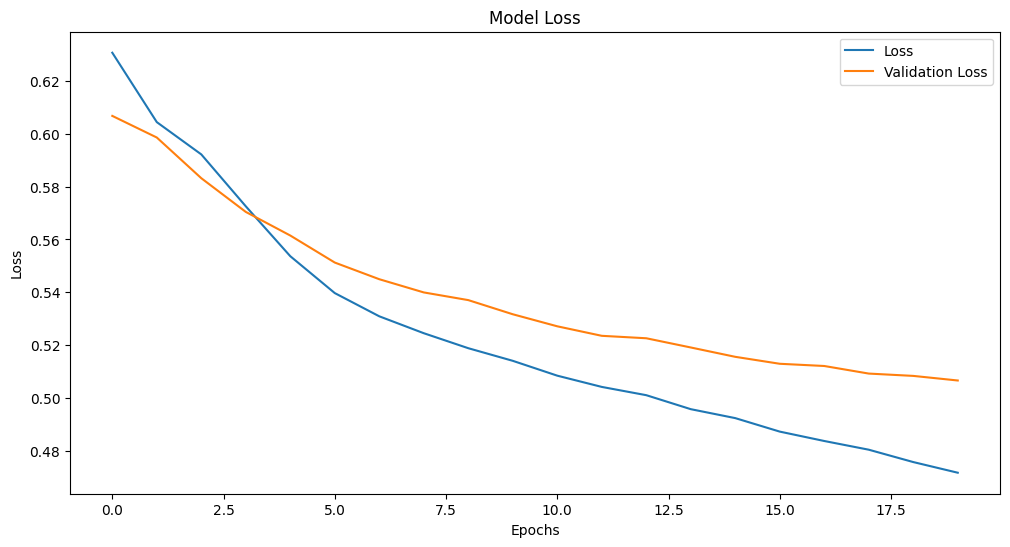

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [35]:
X_test_transformed = scaler.transform(X_test)
predictions = autoencoder.predict(X_test_transformed)
predictions = predictions.reshape(X_test.shape)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
avg_mse = np.mean(mse)
print(avg_mse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
